# Customer Survival Analysis For "Global Credit" UCO

In [20]:
from modelling.survival_analysis import Survival
from modelling.database import engine
from modelling.utils import from_sql_to_pandas

from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
#import ipywidgets as iw
import pandas as pd
import seaborn as sns
import numpy as np

## Getting Data From the Database

**Note:** The survival data generation process is conducted using the `update_survival_data()` procedure in the database. You can find the procedure in the `app/db_setup/sql_queries` folder.

In [21]:
data = from_sql_to_pandas(engine, "survival_data")
data.head()

,cliid,app_id,ap_date,close_date,contractperiod,paidamount,initialamount,exp_int,riskclass,serveddays,...,n_salary,n_vehicles,n_dahk,n_dependents,been_married,sum_dahk,mobile_operator,marz,tenure,event
0,47,436912,2021-06-08 15:39:00,2022-10-14,28,143898.81,80000.0,72.0,Հսկվող,492,...,107000.0,0,0,0,0,0.0,VivacellMTS,ԵՐԵՎԱՆ,8,True
1,156,915224,2021-12-13 14:45:00,2022-02-11,3,106515.25,100000.0,48.0,Ստանդարտ,59,...,86430.0,0,0,0,0,0.0,Beeline,ԿՈՏԱՅՔ,2,True
2,315,641049,2021-09-09 14:02:00,2022-06-14,16,252460.38,200000.0,45.0,Ստանդարտ,277,...,0.0,0,9,0,1,63000.0,Ucom,ԵՐԵՎԱՆ,6,True
3,342,966406,2021-12-30 11:12:00,2022-02-07,16,106637.53,100000.0,72.0,Ստանդարտ,38,...,138053.0,1,7,3,1,95000.0,VivacellMTS,ԳԵՂԱՐՔՈՒՆԻՔ,1,True
4,379,814556,2021-11-11 05:20:00,2022-07-31,34,291203.31,200000.0,72.0,Հսկվող,261,...,426165.0,0,10,3,1,71500.0,Beeline,ԵՐԵՎԱՆ,605,False


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cliid            4694 non-null   int64         
 1   app_id           4694 non-null   int64         
 2   ap_date          4694 non-null   datetime64[ns]
 3   close_date       4694 non-null   datetime64[ns]
 4   contractperiod   4694 non-null   int64         
 5   paidamount       4694 non-null   float64       
 6   initialamount    4694 non-null   float64       
 7   exp_int          4694 non-null   float64       
 8   riskclass        4694 non-null   object        
 9   serveddays       4694 non-null   int64         
 10  ficoscore        4694 non-null   int64         
 11  npaidcount       4694 non-null   int64         
 12  naplcount        4694 non-null   int64         
 13  n_dpds           4694 non-null   int64         
 14  max_dpd          4694 non-null   int64  

# Feature Meaning

- `cliid`: Client ID, a unique identifier for each client.
- `app_id`: Application ID, a unique identifier for each loan application.
- `ap_date`: Application date, the date when the loan application was made.
- `close_date`: Closing date, the date when the loan contract was closed.
- `contractperiod`: Contract period, the duration of the loan contract in months.
- `paidamount`: Amount paid, the total amount paid by the client (with interest).
- `initialamount`: Initial amount, the initial amount of the contract.
- `exp_int`: The interest rate.
- `riskclass`: Risk class, the risk category associated with the client.
- `serveddays`: Served days, the number of days the contract has been active.
- `ficoscore`: FICO score, a measure of credit risk.
- `npaidcount`: Number of past paid loans.
- `naplcount`: Number of past loan applications.
- `n_dpds`: Number of times the client paid the past due date.
- `max_dpd`: Maximum days past due.
- `age`: Age of the client.
- `gender`: Gender of the client.
- `n_salary`: Net salary of the client (AMD).
- `n_vehicles`: Number of vehicles owned by the client.
- `n_dahk`: Number of enforcement proceedings of the client.
- `sum_dahk`: Amount (AMD) of enforcement proceedings of the client.
- `n_dependents`: Number of dependents.
- `been_married`: Marital status (0: Never been married, 1: Has been married).
- `mobile_operator`: Mobile operator used by the client.
- `marz`: Region of the client.
- `tenure`: Tenure, the duration between the client closing his/her latest loan (in 2021) and taking the next.
- `event`: Event, a boolean indicating if an event occurred (i.e. True if took another loan).


In [23]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
cliid,4694.0,560911.138049,47.0,538071.75,584525.0,646695.0,680082.0,148859.228245
app_id,4694.0,621365.942267,215496.0,406987.75,643939.5,838828.75,970966.0,234204.92786
ap_date,4694,2021-08-13 06:05:44.098849792,2021-01-01 11:02:00,2021-05-17 06:34:30,2021-09-10 14:14:30,2021-11-19 05:01:15,2021-12-31 22:40:00,NaN
close_date,4694,2022-05-31 00:18:05.982104832,2021-01-31 00:00:00,2021-12-16 00:00:00,2022-03-23 00:00:00,2022-11-07 18:00:00,2024-03-16 00:00:00,NaN
contractperiod,4694.0,23.431402,0.0,16.0,28.0,33.0,36.0,10.722518
paidamount,4694.0,213500.679708,0.0,120651.6225,174854.92,268875.4375,1292771.0,132062.14175
initialamount,4694.0,163641.60033,50000.0,100000.0,150000.0,200000.0,650000.0,92689.467592
exp_int,4694.0,60.97124,25.0,47.0,57.0,72.0,110.0,18.268187
serveddays,4694.0,290.269493,0.0,72.0,209.0,442.0,1123.0,264.66175
ficoscore,4694.0,566.701321,0.0,537.0,565.0,593.0,765.0,41.838134


A few interesting findings from the above table:
* We have a total of 4690 clients to analyze.
* The average loan size (initial amount) is around 160000 AMD, and the average serving time (served days) is 290 days.
  
Let's also explore average tenure (days between closing a CashMe loan and taking the next) based on event.  

In [5]:
average_tenure_by_event = data.groupby('event')['tenure'].mean()
print(average_tenure_by_event)

event
False    627.709192
True     123.910820
Name: tenure, dtype: float64


* As can be seen, it usually takes 123 days for returning customers to activate their next loan. 

# EDA

* ### Distribution of Numerical Features

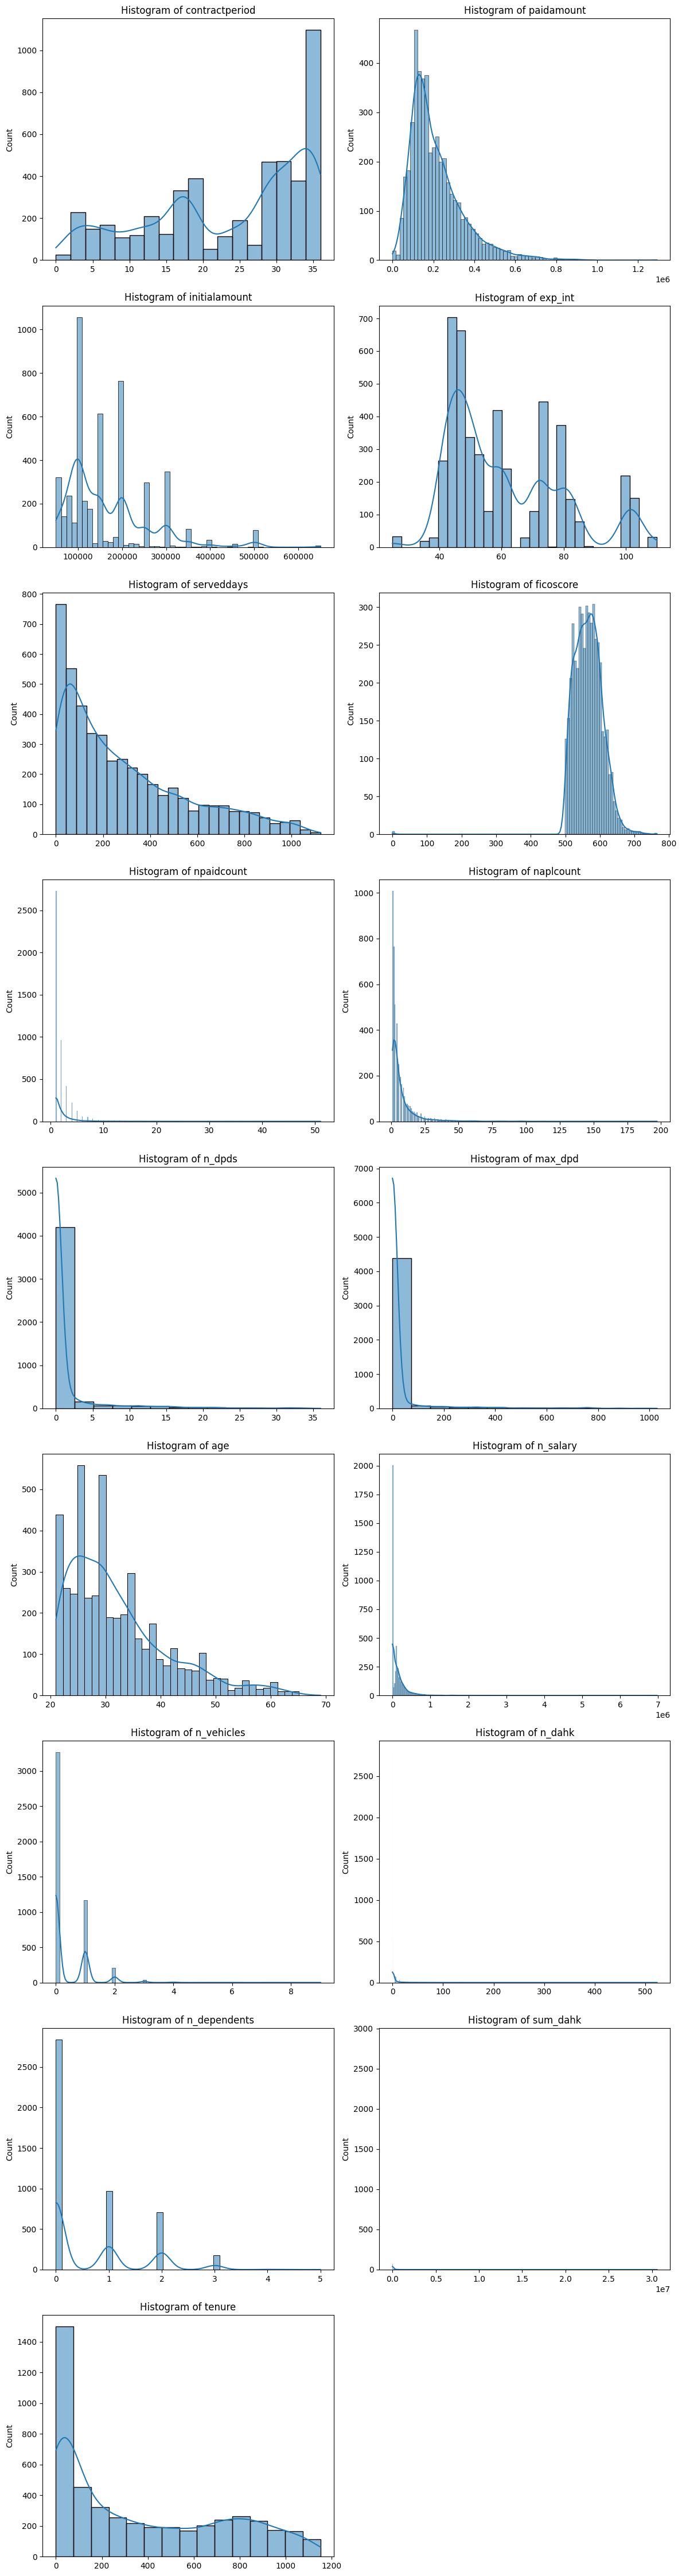

In [24]:
# Determine numeric features by excluding object-type columns
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [i for i in numeric_features if i not in ("cliid", "app_id", "been_married")]

# Determine the layout of subplots dynamically based on the number of numeric features
num_features = len(numeric_features)
num_cols = min(2, num_features)
num_rows = (num_features - 1) // num_cols + 1

# Plot histograms for each numeric feature
plt.figure(figsize=(6 * num_cols, 5 * num_rows))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data, x=feature, kde=True)
    plt.title(f"Histogram of {feature}")
    plt.xlabel("") 

plt.tight_layout()
plt.show()

From the above, we can see a few concerns:
* The distributions of `n_dahk` and `sum_dahk` are heavily skewed, with the great majority of clients having a 0 value for these variables. This can be explained by the fact that most clients probably do not have any legal proceedings against them; thus, for modeling, let's introduce a binary variable called `has_dahk` that will simply record whether the individual has had legal proceedings against them or not.
* The same can be seen for the variable `n_salary`. It's important to note that 0's in the data reflect that the person does not have officially registered income.

In [19]:
data['has_dahk'] = data['n_dahk'].apply(lambda x: 0 if x == 0 else 1)

* ### Distribution of Categorical Features

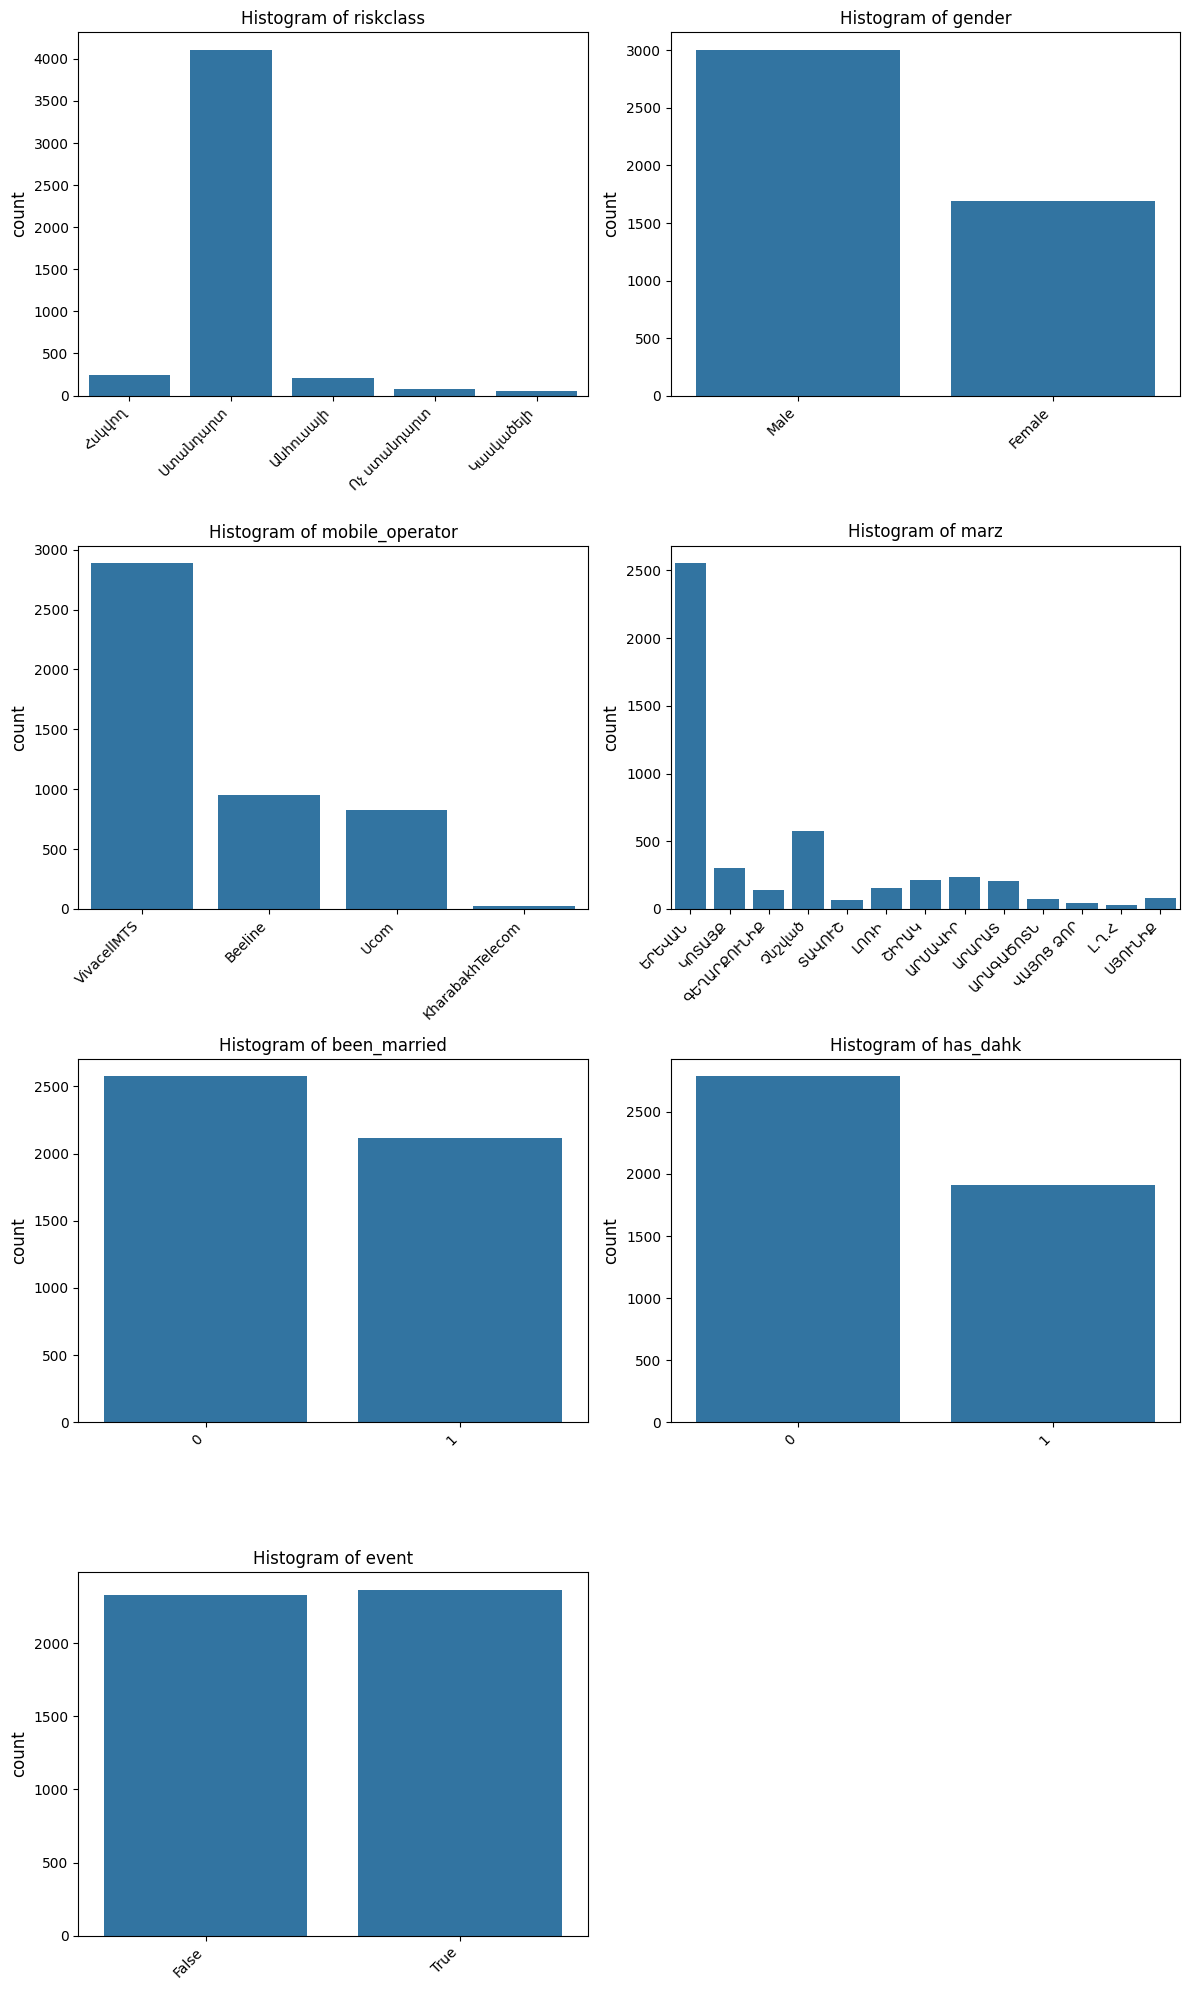

In [8]:
# Define categorical features
categorical_features = ["riskclass", "gender", "mobile_operator", "marz", 'been_married',\
                        'has_dahk','event']

# Determine the layout of subplots dynamically based on the number of categorical features
num_features = len(categorical_features)
num_cols = min(2, num_features)
num_rows = (num_features - 1) // num_cols + 1

# Plot bar charts for each categorical feature
plt.figure(figsize=(6 * num_cols, 5 * num_rows))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(data, x=feature)
    plt.title(f"Histogram of {feature}")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("")
    plt.ylabel('count', fontsize = 12)


plt.tight_layout()
plt.show()

We can see that the distribution of the variable `has_dahk` is much more balanced. 

# Preparing the Data for Modelling

In [9]:
# dummifying categorical variables
encode_cols = ["riskclass", "gender", "mobile_operator", "marz"]

survival_df = pd.get_dummies(
    data, columns=encode_cols, prefix=encode_cols
)

# Specify which dummy columns to drop (reference categories and not meaningful ones)
columns_to_drop = ["riskclass_Ստանդարտ", "gender_Female", "mobile_operator_Ucom",\
                   "marz_ԵՐԵՎԱՆ","app_id", "ap_date", "close_date", "sum_dahk", "n_dahk"]

#exclude the columns not needed for modelling
survival_df = survival_df.drop(columns=columns_to_drop)

In [10]:
survival_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cliid                             4694 non-null   int64  
 1   contractperiod                    4694 non-null   int64  
 2   paidamount                        4694 non-null   float64
 3   initialamount                     4694 non-null   float64
 4   exp_int                           4694 non-null   float64
 5   serveddays                        4694 non-null   int64  
 6   ficoscore                         4694 non-null   int64  
 7   npaidcount                        4694 non-null   int64  
 8   naplcount                         4694 non-null   int64  
 9   n_dpds                            4694 non-null   int64  
 10  max_dpd                           4694 non-null   int64  
 11  age                               4694 non-null   int64  
 12  n_sala

* ### Exploring Correlations

In [11]:
# Calculate correlation matrix
corr_matrix = survival_df.corr()

# Set correlation threshold
threshold = 0.8

# Iterate through the correlation matrix and extract pairs of features with correlation coefficients above the threshold
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation = corr_matrix.iloc[i, j]
            high_corr_pairs.append((feature1, feature2, correlation))

# Print high correlation pairs
print("Highly correlated pairs with correlation coefficient above", threshold)
for pair in high_corr_pairs:
    print(pair[0], "-", pair[1], "- Correlation:", pair[2])


Highly correlated pairs with correlation coefficient above 0.8
paidamount - initialamount - Correlation: 0.9025455979611472
n_dpds - max_dpd - Correlation: 0.92737419413956


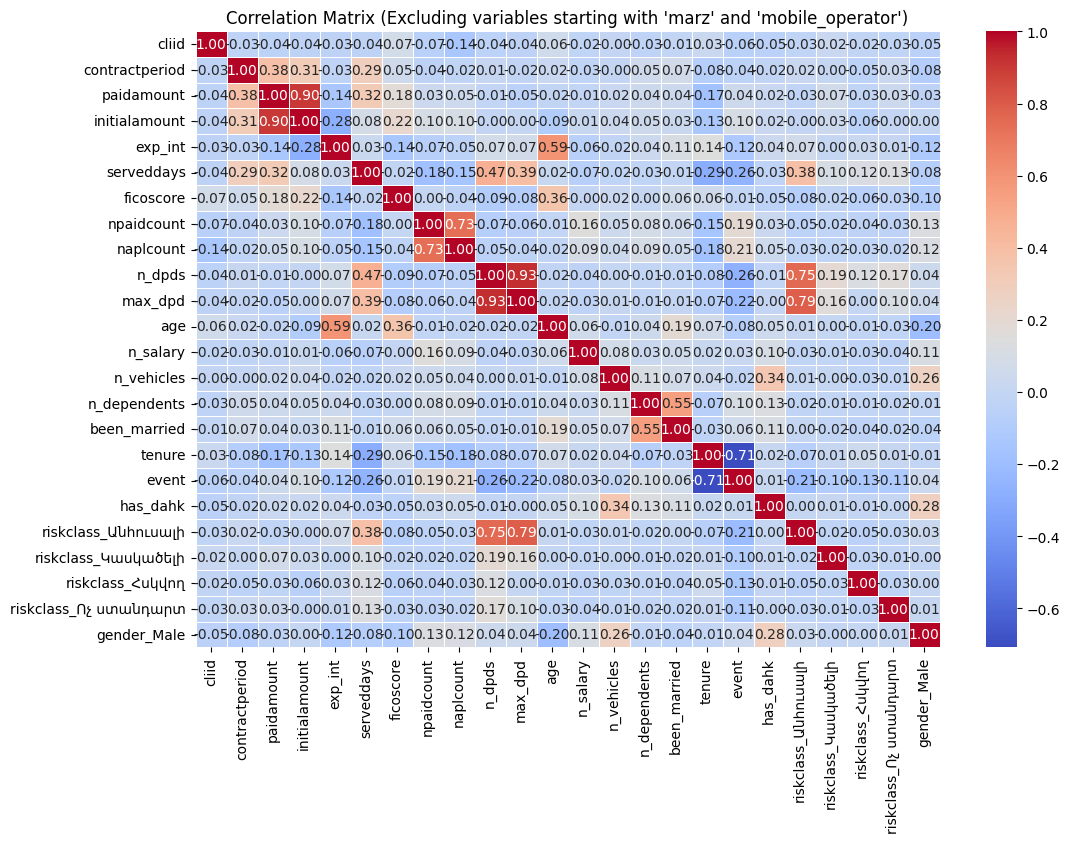

In [12]:
# Filter out columns starting with 'marz' and 'mobile_operator' for the plot to be interpretable
filtered_corr_matrix = corr_matrix.loc[~(corr_matrix.index.str.startswith('marz') | corr_matrix.index.str.startswith('mobile_operator')),
                                       ~(corr_matrix.columns.str.startswith('marz') | corr_matrix.columns.str.startswith('mobile_operator'))]

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, cmap='coolwarm', linewidths=.5, fmt=".2f", annot=True)
plt.title("Correlation Matrix (Excluding variables starting with 'marz' and 'mobile_operator')")
plt.show()


**Feature Selection:**

To avoid multicollinearity, it's advisable to remove highly correlated features. In this case, we'll remove `max_dpd` and `initial_amount`.


In [13]:
surv_data = survival_df.drop(columns = ["initialamount", "max_dpd"])

# Survival Analysis

In [14]:
inst = Survival(
    duration_col="tenure", event_col="event", primary_col="cliid", data=surv_data
)

* # Kaplan-Meier

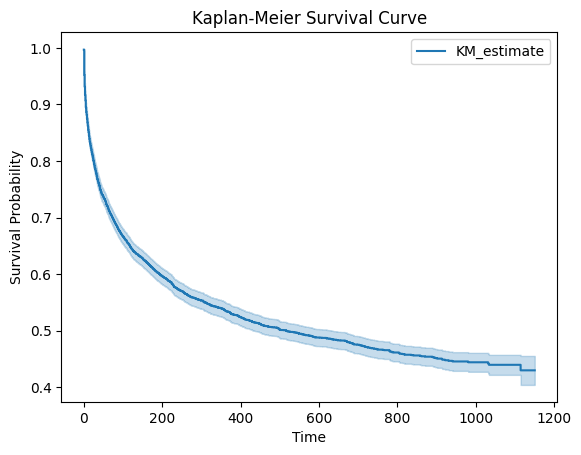

In [15]:
km = inst.fit_kaplan_meier()
inst.plot_kaplan_meier()

**Interpretation:**

The Kaplan-Meier survival curve displayed above exhibits a promising trend - survival probability decreases smoothly with time, suggesting that our data is suitable for modeling purposes.


* # Accelerated Failure Time (AFT)

In [16]:
inst.find_best_aft_model()
aft = inst.fit_best_aft_model(remove_insignificant=False) # so we can observe feature effects
inst.model_summary(aft)

Best distribution: Log-Normal (AIC: 31392.700205122117)


<lifelines.LogNormalAFTFitter: fitted with 4694 total observations, 2328 right-censored observations>
             duration col = 'tenure'
                event col = 'event'
   number of observations = 4694
number of events observed = 2366
           log-likelihood = -15660.350
         time fit was run = 2024-05-09 10:49:15 UTC

---
                                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                          
mu_    age                              -0.010     0.990     0.010          -0.029           0.009               0.972               1.009
       been_married                     -0.156     0.855     0.131          -0.414           0.101               0.661               1.107
       contractperiod                    0.024     1.024     0.005           0.013           0.034               1.013               1.035
       exp_int                           0.028     1.028     0.004           0.019           0.036               1.019               1.037
       ficoscore                         0.010     1.010     0.002           0.006           0.013               1.006               1.013
       gender_Male                      -0.190     0.827     0.123          -0.430           0.050               0.651               1.052
       has_dahk                          0.044     1.045     0.120          -0.190           0.279               0.827               1.322
       marz_ԱՐԱԳԱԾՈՏՆ                   -0.140     0.869     0.418          -0.959           0.679               0.383               1.972
       marz_ԱՐԱՐԱՏ                       0.099     1.104     0.268          -0.426           0.624               0.653               1.866
       marz_ԱՐՄԱՎԻՐ                      0.250     1.284     0.255          -0.250           0.750               0.779               2.116
       marz_ԳԵՂԱՐՔՈՒՆԻՔ                 -0.252     0.777     0.312          -0.864           0.360               0.422               1.433
       marz_Լ.Ղ.Հ                       19.953 4.631e+08 10824.926      -21196.512       21236.419               0.000                 inf
       marz_ԼՈՌԻ                        -0.639     0.528     0.293          -1.214          -0.064               0.297               0.938
       marz_ԿՈՏԱՅՔ                      -0.114     0.893     0.221          -0.547           0.320               0.579               1.377
       marz_ՇԻՐԱԿ                       -0.123     0.884     0.257          -0.627           0.382               0.534               1.465
       marz_Չնշված                      -0.561     0.571     0.172          -0.899          -0.224               0.407               0.800
       marz_ՍՅՈՒՆԻՔ                     -1.203     0.300     0.382          -1.951          -0.454               0.142               0.635
       marz_ՎԱՅՈՑ ՁՈՐ                   -0.198     0.821     0.523          -1.223           0.828               0.294               2.288
       marz_ՏԱՎՈՒՇ                       0.741     2.097     0.479          -0.199           1.680               0.820               5.364
       mobile_operator_Beeline           0.436     1.546     0.171           0.101           0.771               1.106               2.161
       mobile_operator_KharabakhTelecom 20.808 1.088e+09 19190.900      -37592.664       37634.280               0.000                 inf
       mobile_operator_VivacellMTS       0.284     1.329     0.143           0.003           0.565               1.003               1.760
       n_dependents                     -0.268     0.765     0.072          -0.408          -0.127               0.665               0.880
       n_dpds                            0.328     1.388     0.058           0.214           0.442               1.239               1.556
       n_salary                          0.000   

In [17]:
alpha = 0.05
p_values = aft.summary["p"]
significant_covariates = (
    p_values[
 (p_values < alpha)
    ]
    .dropna()
    .index.get_level_values("covariate")
    .unique()
)
print(significant_covariates)

Index(['contractperiod', 'exp_int', 'ficoscore', 'marz_ԼՈՌԻ', 'marz_Չնշված',
       'marz_ՍՅՈՒՆԻՔ', 'mobile_operator_Beeline',
       'mobile_operator_VivacellMTS', 'n_dependents', 'n_dpds', 'n_vehicles',
       'naplcount', 'npaidcount', 'paidamount', 'riskclass_Անհուսալի',
       'riskclass_Կասկածելի', 'riskclass_Հսկվող', 'riskclass_Ոչ ստանդարտ',
       'Intercept'],
      dtype='object', name='covariate')


**Significant Variable Interpretation:**

- **Contract Period:** Each additional unit of the contract period is associated with an increase in the hazard by a factor of 1.024.
- **Interest Rate (exp_int):** A one unit increase in the interest rate is associated with an increase in the hazard by a factor of 1.028.
- **FICO Score (ficoscore):** Each one unit increase in the FICO score is associated with an increase in the hazard by a factor of 1.010.
- **Region (marz_...):** Interpretations vary based on specific regions. For example, the lowest p_value is achieved for region Syuniq, which is associated with a decrease in the hazard by a factor of 0.295 compared to a reference region Yerevan.
- **Mobile Operator (mobile_operator_...):** Interpretations vary based on specific mobile operators. For example, being with operators Beeline and VivacellMTS is associated with an increase in the hazard compared to the reference operator Ucom. However, Kharabagh Telecom is associated with a significant decrease in hazard. 
- **Number of Dependents (n_dependents):** Each additional dependent is associated with a decrease in the hazard by a factor of 0.768.
- **Number of DPDS (n_dpds):** Each additional unit of DPD is associated with an increase in the hazard by a factor of 1.388.
- **Number of Vehicles (n_vehicles):** Each additional vehicle is associated with an increase in the hazard by a factor of 1.359.
- **Number of Paid Loans (npaidcount):** Each additional unit of paid amounts is associated with a decrease in the hazard by a factor of 0.917.
- **Risk Class (riskclass_...):** Interpretations vary based on specific risk classes. Being in risk classes "Հսկվող" or "Ոչ ստանդարտ" is associated with an increase in the hazard compared to the reference risk class "ստանդարտ", whereas "Կասկածելի" and "Անհուսալի" are associated with lower hazard.

**Results Interpretation:**

- **Concordance:** The concordance value of 0.691 indicates the proportion of pairs of subjects whose predicted survival times are correctly ordered among all comparable pairs. A higher concordance value (closer to 1) suggests better predictive performance of the model in terms of survival outcomes.

- **AIC (Akaike Information Criterion):** The AIC value of 31391.330 is a measure of the model's goodness of fit, balancing the trade-off between model complexity and goodness of fit. Lower AIC values indicate better model fit relative to other models.

- **Log-Likelihood Ratio Test:** The log-likelihood ratio test with a test statistic of 1058.631 on 35 degrees of freedom (df) assesses whether the current model significantly improves the fit compared to a baseline model. In this case, a higher test statistic suggests a significant improvement in model fit.

Overall, these results suggest that the model has decent predictive performance with a reasonable concordance value. 


# Exploring Feature Effects

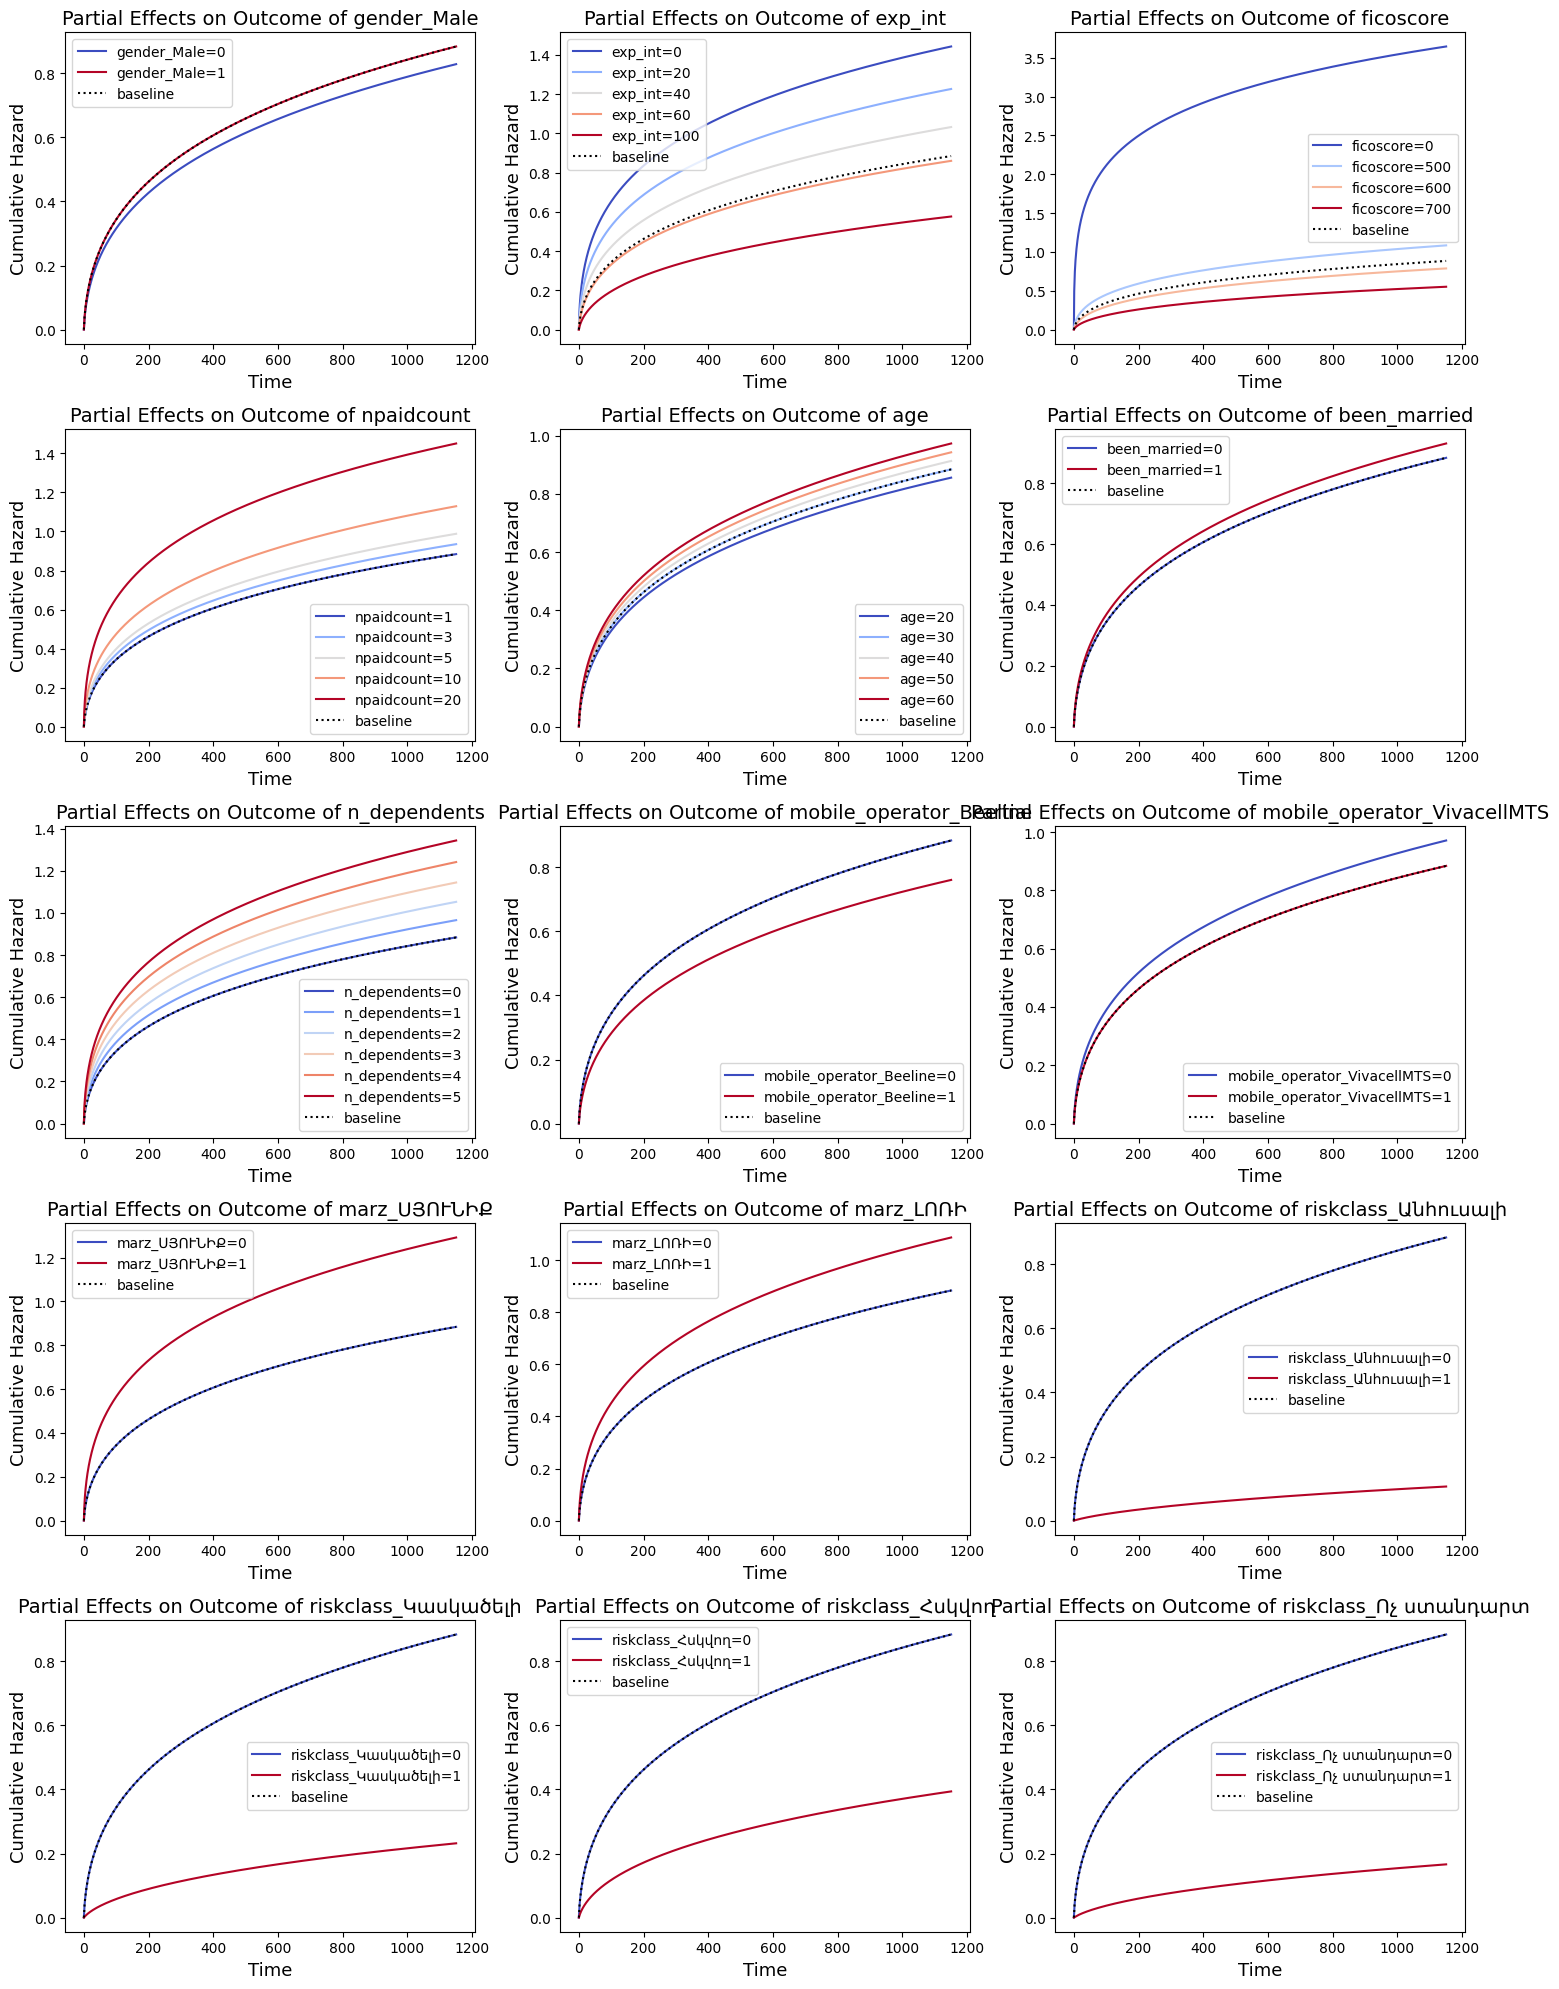

In [18]:
# Define a dictionary mapping each feature to a list of its unique values
feature_values = {
    "gender_Male": [0, 1],
    "exp_int": [0, 20, 40, 60, 100],
    "ficoscore": [0, 500, 600, 700], 
    "npaidcount" : [1, 3, 5, 10, 20], 
    "age": [20, 30, 40, 50, 60],  
    "been_married": [0, 1],
    "n_dependents": [0, 1, 2, 3, 4, 5], 
    "mobile_operator_Beeline": [0, 1], 
    "mobile_operator_VivacellMTS": [0, 1],
    "marz_ՍՅՈՒՆԻՔ": [0, 1], 
    "marz_ԼՈՌԻ": [0, 1], 
    "riskclass_Անհուսալի": [0, 1], 
    "riskclass_Կասկածելի": [0, 1], 
    "riskclass_Հսկվող": [0, 1], 
    "riskclass_Ոչ ստանդարտ": [0, 1]
}

# Plot partial effects on outcome for each mapping
num_plots = len(feature_values)
num_rows = int(np.ceil(num_plots / 3))  # Adjust the number of rows as per your preference
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 4 * num_rows))

for i, (feature, values) in enumerate(feature_values.items()):
    row = i // 3
    col = i % 3
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    inst.partial_effects_on_outcome(aft, feature, values, ax=ax)
    ax.set_title(f"Partial Effects on Outcome of {feature}", fontsize=14)

plt.tight_layout()
plt.show()


A few interesting insights about the feature impacts:
* **Gender**: Males have a slightly higher probability of reactivating another loan than females.
* **Interest Rate**: The lower the interest rate of the clients' previous loan, the higher the likelihood of him/her returning to take another one.
* **FICO Score:** The lower the FICO Score, the higher the probability of him/her taking another loan. Moreover, if the client has no previous loan history (FICO Score is 0), then he/she is significantly more likely to take a new loan.
* **Number of Closed Loans:** The more loans the client has paid off in the Company, the higher the likelihood that the client will take another one.
* **Age:** The older the client, the higher the likelihood of him/her taking another loan.
* **Marital Status:** Having been married also slightly increases the likelihood of the event occurring.
* **Number of Dependents:** The more dependent the client has, the higher the likelihood of him returning to take another loan.
* **Mobile Operator:** In comparison with the Ucom mobile operator, customers of Beeline and VivacellMTS have a lower likelihood of the event occurring.
* **Region:** In comparison with Yerevan, being from the regions of Syuniq and Lori also negatively impacts the likelihood of a client returning for another loan.
* **Risk Class:** Not having a "Standard" risk class is also associated with a lower likelihood of the client returning to take another loan. 